## Model Training with FEAST
- This notebook performs Model Training and Scoring by building the train/test dataset using features from Feast Feature Store
  - Feast for Feature Store
  - Uses Azure Storage Account
  - Uses MLFlow

### Prerequisites
- Ensure  **Feature Definitions and Feature Registrations** pertaining to the Home Credit Risk Default usecase is executed. Registry.db is created

In [9]:
%pip install feast-azure-provider==0.3.0
%pip install azure-cli
%pip install snowflake-connector-python==2.7.4
%pip install pyarrow==6.0.1
%pip install lightgbm
%pip install mlflow
%pip install pyarrow==6.0.1

  Using cached feast-0.18.1-py3-none-any.whl (275 kB)
  Attempting uninstall: feast
    Found existing installation: feast 0.18.0
    Uninstalling feast-0.18.0:
      Successfully uninstalled feast-0.18.0
Note: you may need to restart the kernel to use updated packages.
ERROR: azureml-core 1.38.0 has requirement knack~=0.8.2, but you'll have knack 0.9.0 which is incompatible.
  Attempting uninstall: portalocker
    Found existing installation: portalocker 2.3.2
    Uninstalling portalocker-2.3.2:
      Successfully uninstalled portalocker-2.3.2
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Feast yaml file referencing offline store and registry.db in blob storage

- Set environment variable
- Set feature_store.yaml File configuration in tmp

In [11]:
from azureml.core import Workspace
from azureml.core import Keyvault
import os

ws = Workspace.from_config()
keyvault = ws.get_default_keyvault()

In [12]:
import os
os.environ["REGISTRY_BLOB_KEY"] = keyvault.get_secret("registrytoken")

In [13]:
#Configuration
repo_path = "/tmp" #Feast Feature Repo Path
if not os.path.exists(repo_path):
    os.makedirs(repo_path)

In [14]:
path = "<REGISTRY_BLOB_STORAGE>" # https://<STORAGE_NAME>.blob.core.windows.net/featurestore/registry.db"
account = "feast-dev"

sf_feature_store_config="""
project: eh_credit_01
registry: 
    registry_store_type: feast_azure_provider.registry_store.AzBlobRegistryStore
    path: {}    
provider: feast_azure_provider.azure_provider.AzureProvider
offline_store:
    type: snowflake.offline
    account: {}
    user: evan_hou
    password: {}
    role: DSA_USER_ROLE
    warehouse: COMMON_WH
    database: TEST
online_store:
    type: sqlite
    path: data/online.db
""".format(path, account, keyvault.get_secret("sfaccesskey1"))

In [15]:
with open(repo_path+'/feature_store.yaml', 'w') as f:
    lines = f.write(sf_feature_store_config)

#### Load Training data using feast

In [16]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import mlflow
import mlflow.lightgbm

import time
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta

from feast import FeatureStore

In [19]:
#Login Details for snowflake
username = "sakthivel_baskaran"

pwd = keyvault.get_secret("sfaccesskey2")

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/urllib3/util/retry.py:437: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  warnings.warn(


In [20]:
import snowflake.connector as snow
from snowflake.connector.pandas_tools import write_pandas

# Snowflake python connector to populate data from datasource to table in snowflake
conn = snow.connect(
   user = username,
   password = pwd,
   account="<ACCOUNT_NAME>",
   warehouse="COMMON_WH",
   database="TEST",
   schema="PUBLIC"
)

03/25/2022 07:23:53 AM INFO:Snowflake Connector for Python Version: 2.7.4, Python Version: 3.8.1, Platform: Linux-5.4.0-1068-azure-x86_64-with-glibc2.10
03/25/2022 07:23:53 AM INFO:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
03/25/2022 07:23:53 AM INFO:Setting use_openssl_only mode to False


In [21]:
cur = conn.cursor()

sql = 'select  * from  "TEST"."PUBLIC"."APPLICATION_TRAIN"'
cur.execute(sql)
id_train = cur.fetch_pandas_all()

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
03/25/2022 07:24:00 AM INFO:query: [select  * from  "TEST"."PUBLIC"."APPLICATION_TRAIN"]
03/25/2022 07:24:00 AM INFO:query execution done


In [22]:
# load labels from snowflake or locally stored file
# id_train = pd.read_csv('/dbfs/FileStore/application_train.csv')[['SK_ID_CURR', 'TARGET']]

id_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 3727
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int16(2), int32(2), int8(37), object(16)
memory usage: 206.8+ MB


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
from datetime import datetime
from feast import FeatureStore
import pandas as pd

# load features from Feast
repo_path = "/tmp/" #Feast Feature Repo Path
fs = FeatureStore(repo_path)
entity_df = pd.DataFrame.from_dict(
    {
        "SK_ID_CURR": id_train['SK_ID_CURR'].tolist(),
        "TARGET": id_train['TARGET'].tolist(),
        "event_timestamp": [datetime(2022,2,24)]*id_train.shape[0]
    }
)

# use feature service of this model
feature_service = fs.get_feature_service("eh_dbr_credit_model")
train_df = fs.get_historical_features(
    entity_df=entity_df,
    features=feature_service
).to_df()

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/feast/feature_view.py:100: DeprecationWarning: The argument 'input' is being deprecated. Please use 'batch_source' instead. Feast 0.13 and onwards will not support the argument 'input'.
  warnings.warn(


#### Preprocessing Data

In [32]:
# # drop id and timestamp
train_df = train_df.sort_values(by='SK_ID_CURR')
train_df = train_df.drop(columns = ['event_timestamp', 'SK_ID_CURR'])

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
train_df.info()

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 929 to 37071
Data columns (total 45 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   TARGET                                                  307511 non-null  int8   
 1   OCCUPATION_TYPE                                         211120 non-null  object 
 2   AMT_INCOME_TOTAL                                        307511 non-null  float64
 3   NAME_INCOME_TYPE                                        307511 non-null  object 
 4   DAYS_LAST_PHONE_CHANGE                                  307510 non-null  float64
 5   ORGANIZATION_TYPE                                       307511 non-null  object 
 6   AMT_CREDIT                                              307511 non-null  float64
 7   AMT_GOODS_PRICE                                         307233 non-null  float64
 8   DAYS_REGISTRATION      

#### Model Training

In [34]:
y = train_df['TARGET']
X = train_df.drop(columns = ['TARGET'])

# encode category features
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
        X[c] = X[c].cat.codes

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print( len(X_train), len(y_train), sum(y_train))
print( len(X_valid), len(y_valid), sum(y_valid))
print( len(X_test), len(y_test), sum(y_test))

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


123004 123004 9857
92254 92254 7579
92253 92253 7389


In [36]:
mlflow.lightgbm.autolog()

with mlflow.start_run(run_name="lgbm_simple"):

    # LightGBM parameters found by Bayesian optimization
    clf = lgb.LGBMClassifier(
                    objective="binary",
                    n_estimators=1000,
                    learning_rate=0.01,
                    num_leaves=34,
                    max_depth=9,
                    random_state=42
                )

    clf.fit(X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric=["AUC","binary_logloss"],
            verbose= 100,
            early_stopping_rounds= 100
           )

    # # evaluate model: ROC AUC
    y_pred_proba = clf.predict_proba(X_test)
    roc_auc = metrics.roc_auc_score(y_test, y_pred_proba[:, 1])
    print(f"ROC AUC score: {roc_auc:.2f}")


    # log metrics
    mlflow.log_metrics({"roc_auc": roc_auc})




2022/03/25 07:26:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.7419	valid_0's binary_logloss: 0.259417
[200]	valid_0's auc: 0.752587	valid_0's binary_logloss: 0.252845
[300]	valid_0's auc: 0.757545	valid_0's binary_logloss: 0.250212
[400]	valid_0's auc: 0.760247	valid_0's binary_logloss: 0.248974
[500]	valid_0's auc: 0.761782	valid_0's binary_logloss: 0.248333
[600]	valid_0's auc: 0.762936	valid_0's binary_logloss: 0.247921
[700]	valid_0's auc: 0.763447	valid_0's binary_logloss: 0.247708
[800]	valid_0's auc: 0.763758	valid_0's binary_logloss: 0.247571
[900]	valid_0's auc: 0.764052	valid_0's binary_logloss: 0.247461
[1000]	valid_0's auc: 0.764253	valid_0's binary_logloss: 0.247382
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.764261	valid_0's binary_logloss: 0.247378


03/25/2022 07:27:21 AM INFO:Parsing artifact uri azureml://experiments/Default/runs/6d679188-b6ba-405d-8f6a-73631dfc7820/artifacts
03/25/2022 07:27:21 AM INFO:Artifact uri azureml://experiments/Default/runs/6d679188-b6ba-405d-8f6a-73631dfc7820/artifacts info: {'experiment': 'Default', 'runid': '6d679188-b6ba-405d-8f6a-73631dfc7820'}
2022/03/25 07:27:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/urllib3/util/retry.py:437: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead"
2022/03/25 07:27:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/mlflow/types/utils.py:148: DeprecationWarning: ``mlflow.types.schema.column_types`` is deprecated since 1.14. This method will be removed in a near future release. Use ``mlflow.types.Schema.

ROC AUC score: 0.76


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


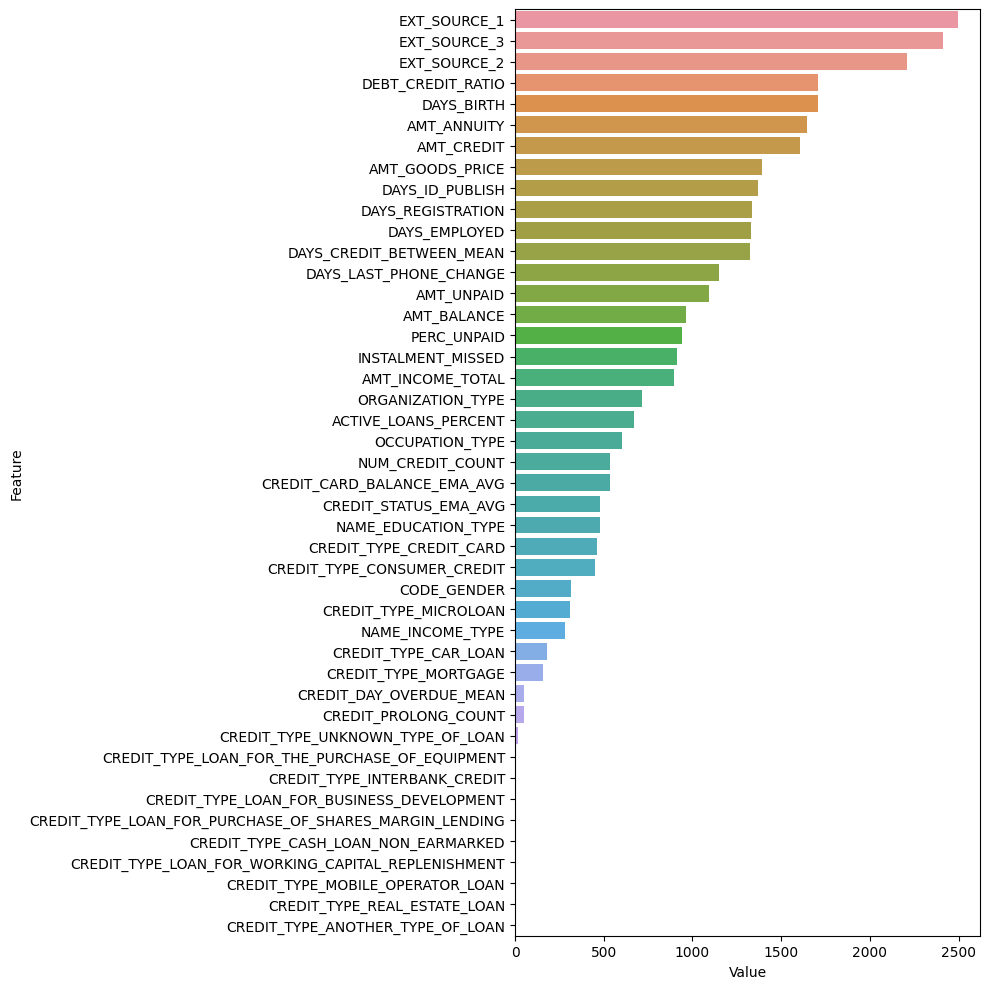

In [37]:
# feature importance

import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.tight_layout()
plt.show()
# feature_imp.sort_values(by="Value", ascending=False).head()
# plt.savefig('lgbm_importances-01.png')

In [38]:
# Evaluation

y_pred_proba = clf.predict_proba(X_test)[:, 1]
roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC score: {roc_auc:.2f}")

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2022/03/25 07:27:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/mlflow/sklearn/__init__.py:649: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations"


ROC AUC score: 0.76


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


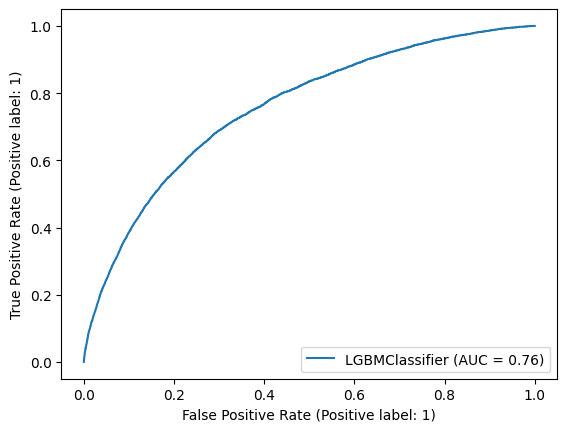

In [39]:
metrics.plot_roc_curve(clf, X_test, y_test)
plt.show()

In [40]:
# Data to plot precision - recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = metrics.auc(recall, precision)
print(f"precision-recall AUC score: {auc_precision_recall:.2f}")

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2022/03/25 07:27:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/mlflow/sklearn/__init__.py:649: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations"


precision-recall AUC score: 0.24


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


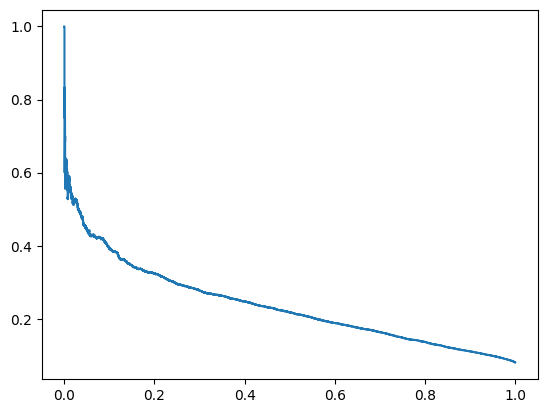

In [41]:
plt.plot(recall, precision)
plt.show()